## Virtual Screening MultiProcessor Using GOLD

In [1]:
import os
import argparse
import time
import glob
import pandas as pd
import numpy as np

from ccdc.docking import Docker
from ccdc import io
from ccdc.io import MoleculeReader, EntryReader, MoleculeWriter, EntryWriter

from ccdc import conformer
from ccdc.conformer import ConformerGenerator, ConformerSettings
from ccdc.screening import Screener

from ccdc.protein import Protein

import multiprocessing
from multiprocessing import Pool

### Enviroment Settings
The enviroment must be set as follow:
- you need a folder called "ligands" where you will add all the ligands that you want to dock in mol2 format
- inside this folder must be also the cristallized ligand called "cristal.mol"
- in the same directory where you put this script, must be the protein that you want to use
- you must insert the basename of the protein

In [2]:
# Choose the name of the protein that you want to use for the docking
user = input("Select protein (basename): ")
protein = user + ".pdb"

# Some folder creation
try:
    ligands_prep_folder = "ligands_prepared"
    os.mkdir(ligands_prep_folder)
except:
    pass
try:
    output_folder = "output"
    os.mkdir(output_folder)
except:
    pass

### Ligand Preparation

In [3]:
# Grab the filenames of the ligands to dock
ligands_full = glob.glob("./ligands/*.mol2")
ligands_basename = [x.split("/")[2] for x in ligands_full]

In [4]:
def prepare_ligand (ligand_to_prep):
    '''
    Ligand preparation, it does a stocastic conformational search of 200 conformer. It minimize all of them and then it pick the one with lowest energy
    
    '''
    ligand_prep = Docker.LigandPreparation()
    ligand_prep.settings.add_hydrogens = True

    prepared_lig = ligand_prep.prepare(EntryReader(f"./ligands/{ligand_to_prep}")[0])
    with MoleculeWriter(f'ligands/{ligand_to_prep}') as mol_writer:
        mol_writer.write(prepared_lig.molecule)
    
    
    mol_reader = io.MoleculeReader(f"./ligands/{ligand_to_prep}")
    mol = mol_reader[0]
    conformer_generator = conformer.ConformerGenerator()
    conformer_generator.settings.max_conformers = 200
    conformer_generator.settings.superimpose_conformers_onto_reference = True

    conformers = conformer_generator.generate(mol)
    conformers_mols = [c.molecule for c in conformers]

    most_probable_conformer = conformers_mols[0]

    io.MoleculeWriter(f"./ligands_prepared/prep_{ligand_to_prep}").write(most_probable_conformer)

In [5]:
for ligand in ligands_basename:
    prepare_ligand(ligand)

INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul
INFO: /home/hitesit/CCDC/CSD_2022/bin/mogul


### Prepare Protein

In [6]:
prot_entry = Protein.from_file(protein)

In [7]:
# It prepare the protein: removing Water, removing HETATM, adding Hydrogens
prot_entry.remove_all_waters()
prot_entry.remove_unknown_atoms()
prot_entry.add_hydrogens()
lig_prot = prot_entry.ligands
prot_prepared_filename = protein.split(".")[0] + "_clean.pdb"

for l in lig_prot:
    prot_entry.remove_ligand(l.identifier)
with EntryWriter(prot_prepared_filename) as writer:
    writer.write(prot_entry)

### Dock

In [8]:
# Enviromental Variables
docker = Docker()
settings = docker.settings

In [9]:
def docking(params):

    prot = params[0]
    cristal = params[1]
    lig = params[2]
    folder_output = params[3]
    runs = params[4]

    # Objects
    protein_file = os.path.abspath(prot)
    ligand_file = os.path.abspath(lig)
    native_ligand_file = os.path.abspath(cristal)

    # Protein and Ligand
    protein = Protein.from_file(protein_file)
    ligand = MoleculeReader(ligand_file)[0]
    
    # Binding Box and Cristal
    native_ligand = MoleculeReader(native_ligand_file)[0]
    settings.add_protein_file(protein_file)
    settings.add_ligand_file(ligand_file, runs)
    settings.reference_ligand_file = cristal
    settings.binding_site = settings.BindingSiteFromLigand(protein, native_ligand, 8.0)

    # Engine Settings
    settings.fitness_function = 'plp'
    settings.rescore_function = "chemscore"
    settings.autoscale = 100.
    settings.early_termination = False
    settings.write_options = ["NO_LINK_FILES"]
    settings.diverse_solutions = (True, 10, 1.5)

    # Output Handling
    lig_basename = lig.split("/")[1]
    lig_folder = os.path.join("output", lig_basename)

    settings.output_directory = lig_folder
    settings.output_file = f"{lig_basename}_merge.mol2"

    docker.dock(file_name=f"{lig_basename}.conf")
    docker.dock(file_name=os.path.join(lig_folder, f"{lig_basename}.conf"))

In [10]:
ligands_prepared = glob.glob(f"{ligands_prep_folder}/*.mol2")
runs = 10

### Multiprocessing

In [11]:
params = [(prot_prepared_filename, "./ligands/cristal.mol2", lig, output_folder, 10) for lig in ligands_prepared]

In [12]:
import ccdc.utilities
if __name__ == '__main__':
    with Pool(16) as p:
        p.map(docking, params)

Starting GOLD with conf file /mnt/e/1_Coding/1_Script_Github/Chem_Script_Repo/GOLD_Virtual_Screening/prep_VS_2.mol2.confStarting GOLD with conf file /mnt/e/1_Coding/1_Script_Github/Chem_Script_Repo/GOLD_Virtual_Screening/prep_AF_1_R.mol2.confStarting GOLD with conf file /mnt/e/1_Coding/1_Script_Github/Chem_Script_Repo/GOLD_Virtual_Screening/prep_cristal.mol2.conf

Starting GOLD with conf file /mnt/e/1_Coding/1_Script_Github/Chem_Script_Repo/GOLD_Virtual_Screening/prep_VS_1.mol2.conf

Unsetting the LD_LIBRARY_PATH environment variable.
Previous value was /usr/local/gromacs/lib
Please do not rely on CCDC wrapper scripts doing this and ensure the directories in LD_LIBRARY_PATH do not interfere with CCDC provided libraries.
Unsetting the LD_LIBRARY_PATH environment variable.
Previous value was /usr/local/gromacs/lib
Please do not rely on CCDC wrapper scripts doing this and ensure the directories in LD_LIBRARY_PATH do not interfere with CCDC provided libraries.
Unsetting the LD_LIBRARY_PATH

### Single Core

for lig in ligands_prepared:
    params = (prot_prepared_filename, "./ligands/cristal.mol2", lig, output_folder, 10)
    results = docking(params)

### Analysis Results

In [13]:
conf_files = glob.glob("*.conf")

In [14]:
full_dict = {}
for file in conf_files:
    settings = Docker.Settings.from_file(file)
    results = Docker.Results(settings)
    ligands_scored = results.ligands

    all_dict = {}
    for num in range(0, len(ligands_scored)):
        mydict = ligands_scored[num].scoring_term("fitness")
        all_dict[f"pose_{num + 1}"] = mydict

    full_dict[f"{file}"] = all_dict

In [15]:
df = pd.DataFrame.from_dict({(i,j,k): full_dict[i][j][k]
                             for i in full_dict.keys()
                             for j in full_dict[i].keys()
                             for k in full_dict[i][j].keys()},
                            orient='index')
df.index = pd.MultiIndex.from_tuples(df.index, names=["Mol", "Pose", "Score"])
df.columns = ['Values']

In [16]:
df_sort = df.sort_values(by=["Score", "Mol", "Values"], ascending=[False, True, False])

In [18]:
df_reset = df.reset_index()

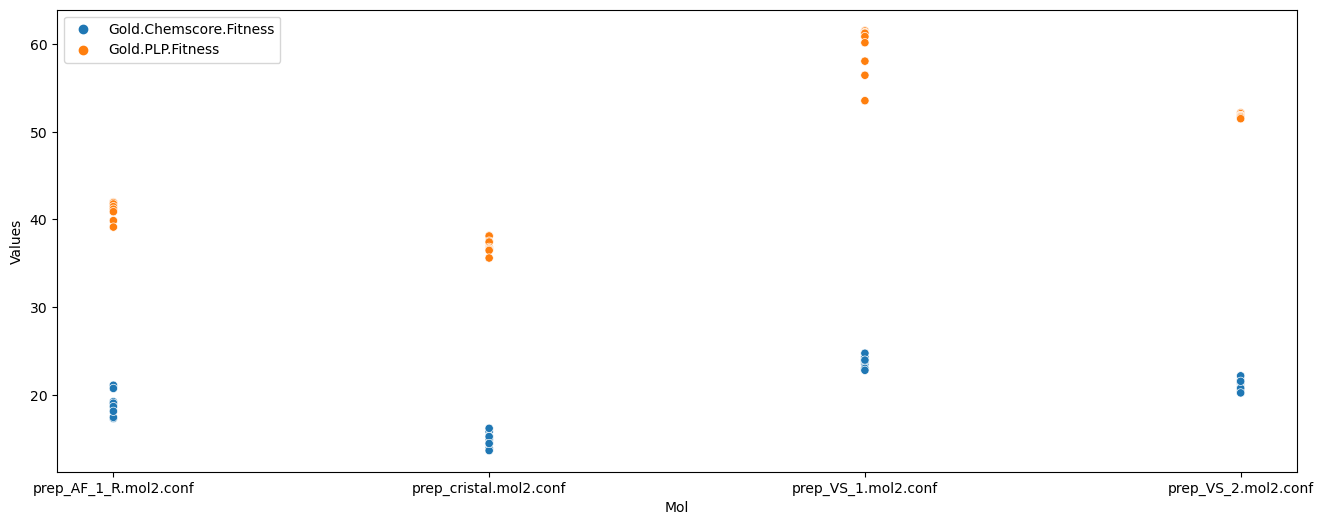

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
ax = sns.scatterplot(data=df, x="Mol", y="Values", hue="Score")
ax.legend(loc=2)